In [1]:
import numpy as np
from pathlib import Path
import nibabel as nib
import random

# --- Paths ---
in_root = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")
pred_root = Path("/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam")

subtypes = [
    "amyloid_plaque_patches",
    "c_fos_positive_patches",
    "cell_nucleus_patches",
    "vessels_patches",
]

N_SAMPLES_PER_SUBTYPE = 3   # random examples per subtype
RANDOM_SEED = 123
random.seed(RANDOM_SEED)

def find_label_for_pred(img_dir: Path, base_name: str):
    """
    base_name is something like 'patch_000_vol000_ch0' or 'patch_000_vol000_ch1'.
    Try to find an appropriate label NIfTI:
      - first try base_name + '_label.nii.gz'
      - if that fails and base_name has '_ch1', try swapping to '_ch0' + '_label.nii.gz'
    """
    # e.g. patch_000_vol000_ch0_label.nii.gz
    label1 = img_dir / f"{base_name}_label.nii.gz"
    if label1.is_file():
        return label1

    if "_ch1" in base_name:
        alt_base = base_name.replace("_ch1", "_ch0")
        label2 = img_dir / f"{alt_base}_label.nii.gz"
        if label2.is_file():
            return label2

    return None

examples = []  # (subtype, channel_str, img_norm, pred_instances, gt)

for st in subtypes:
    img_dir = in_root / st
    pred_dir = pred_root / st

    if not img_dir.is_dir():
        print(f"[WARN] Image dir missing for {st}: {img_dir}")
        continue
    if not pred_dir.is_dir():
        print(f"[WARN] Pred dir missing for {st}: {pred_dir}")
        continue

    # Pick up preds for both ch0 and ch1
    pred_files = sorted(pred_dir.glob("patch_*_ch*_micro_sam_instances.nii.gz"))
    if not pred_files:
        print(f"[WARN] No prediction files found for {st}")
        continue

    chosen = random.sample(pred_files, k=min(N_SAMPLES_PER_SUBTYPE, len(pred_files)))

    for pred_path in chosen:
        # pred name: patch_XXX_volYYY_ch0_micro_sam_instances.nii.gz
        pred_name = pred_path.name
        base_name = pred_name.replace("_micro_sam_instances.nii.gz", "")  # patch_..._ch0 or patch_..._ch1
        channel_str = "ch0" if "_ch0" in base_name else ("ch1" if "_ch1" in base_name else "unknown")

        img_path = img_dir / f"{base_name}.nii.gz"
        if not img_path.is_file():
            print(f"[WARN] Image not found for pred {pred_name}: {img_path}")
            continue

        label_path = find_label_for_pred(img_dir, base_name)
        if label_path is None:
            print(f"[WARN] No label found for pred {pred_name} (base={base_name}), skipping.")
            continue

        # Load volumes
        img = nib.load(str(img_path)).get_fdata().astype(np.float32)
        pred_instances = nib.load(str(pred_path)).get_fdata().astype(np.uint32)
        gt = nib.load(str(label_path)).get_fdata().astype(np.int32)

        # Basic sanity
        if img.shape != pred_instances.shape or img.shape != gt.shape:
            print(f"[WARN] Shape mismatch for {pred_name}: "
                  f"img={img.shape}, pred={pred_instances.shape}, gt={gt.shape}")
            continue

        # Normalize image to [0,1] for plotting
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img_norm = (img - vmin) / (vmax - vmin)
        else:
            img_norm = img

        examples.append((st, channel_str, img_norm, pred_instances, gt))

print(f"Collected {len(examples)} examples total.")


[WARN] No prediction files found for c_fos_positive_patches
Collected 8 examples total.


In [2]:
def get_best_slice(gt_volume: np.ndarray) -> int:
    """
    Choose a z-slice index where the GT has the most foreground.
    If GT is all-zero, fall back to the central slice.
    """
    if gt_volume.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {gt_volume.shape}")
    z_sums = (gt_volume > 0).reshape(gt_volume.shape[0], -1).sum(axis=1)
    if z_sums.max() == 0:
        return gt_volume.shape[0] // 2
    return int(np.argmax(z_sums))


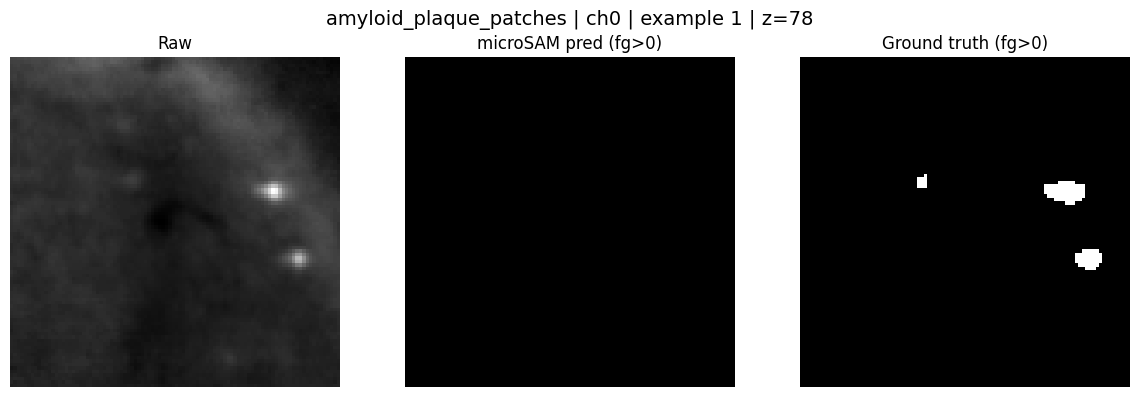

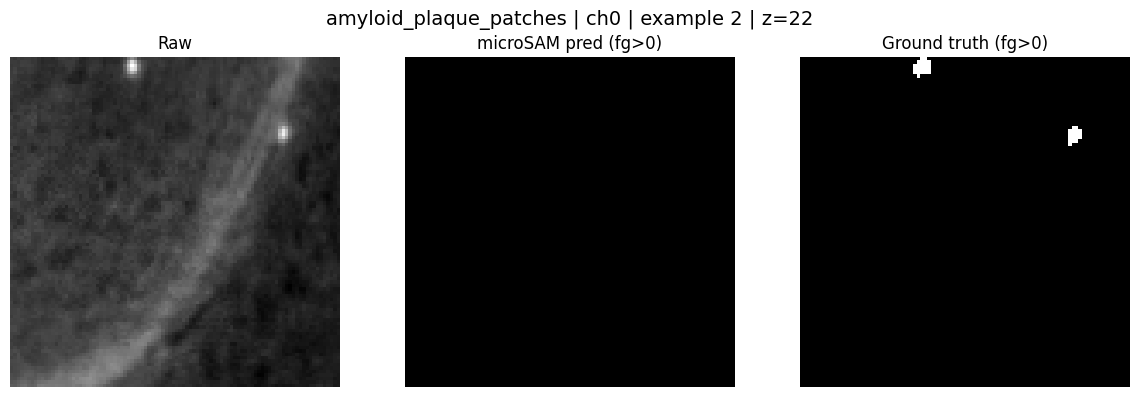

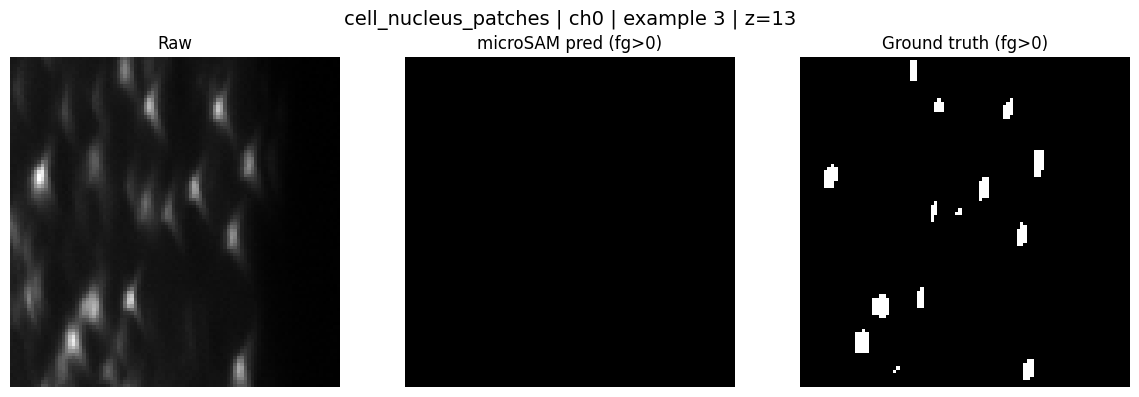

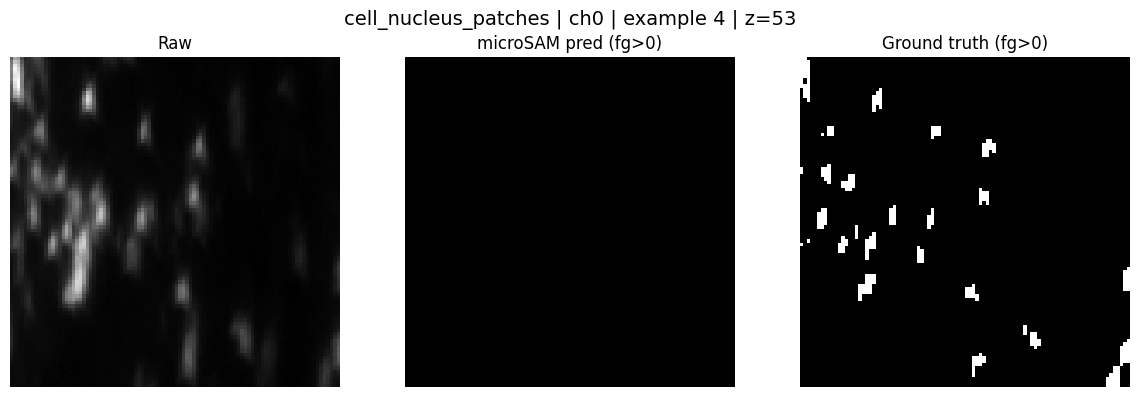

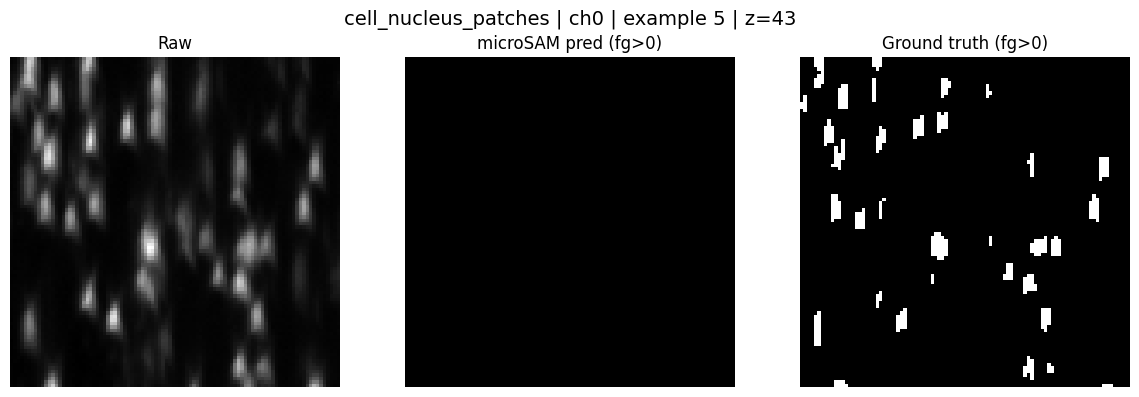

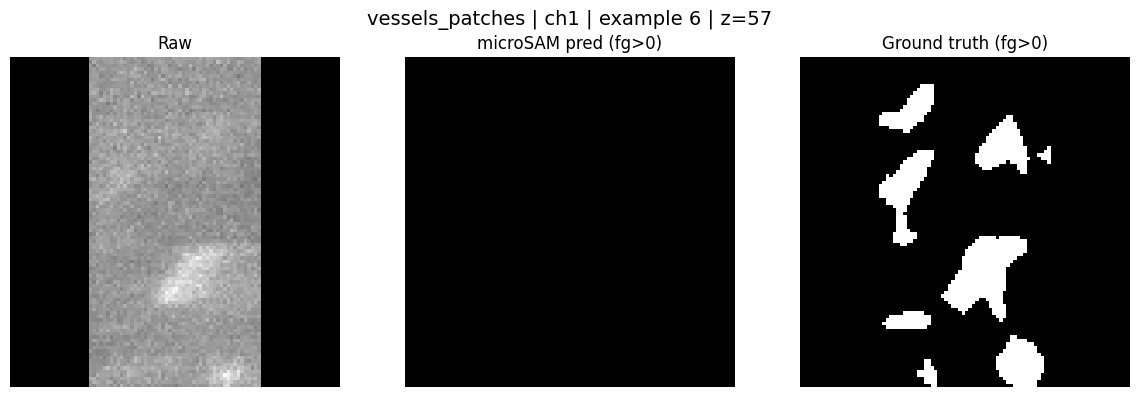

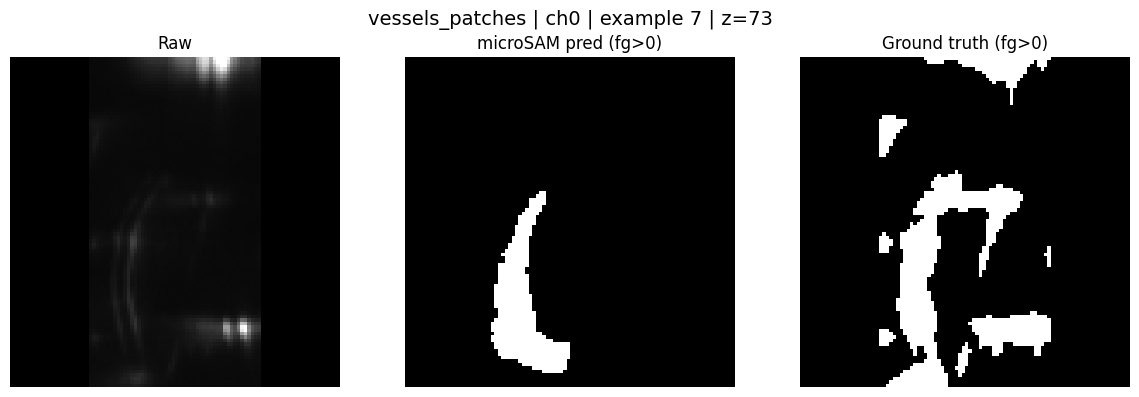

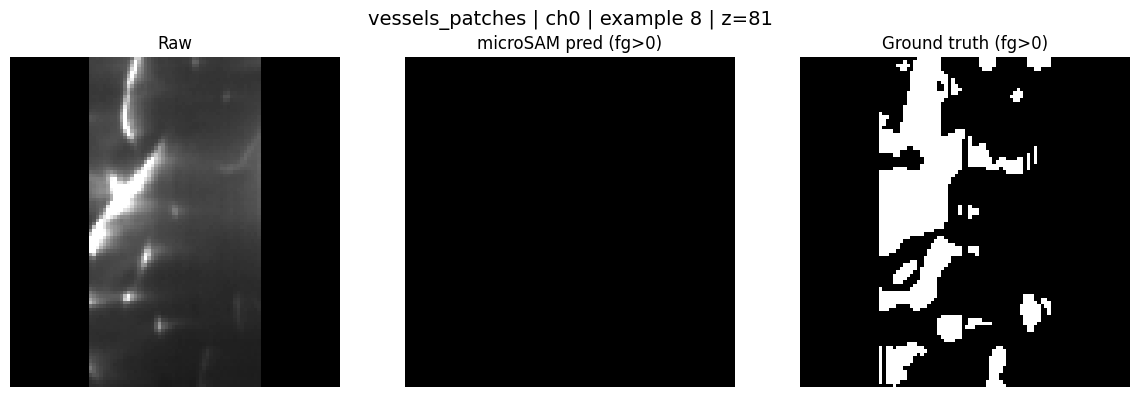

In [3]:
import matplotlib.pyplot as plt

RAW_CMAP = "gray"
MASK_CMAP = "magma"   # adjust if you like

for idx, (st, ch, img_norm, pred_instances, gt) in enumerate(examples, start=1):
    z = get_best_slice(gt)

    img_slice = img_norm[z]
    pred_slice = (pred_instances[z] > 0).astype(float)  # binary foreground
    gt_slice = (gt[z] > 0).astype(float)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"{st} | {ch} | example {idx} | z={z}", fontsize=14)

    # Raw image
    ax = axes[0]
    ax.imshow(img_slice, cmap=RAW_CMAP)
    ax.set_title("Raw")
    ax.axis("off")

    # microSAM prediction overlay
    ax = axes[1]
    ax.imshow(img_slice, cmap=RAW_CMAP)
    ax.imshow(pred_slice, cmap='gray')
    # ax.imshow(
    #     np.ma.masked_where(pred_slice == 0, pred_slice),
    #     cmap=MASK_CMAP,
    #     alpha=0.5,
    # )
    ax.set_title("microSAM pred (fg>0)")
    ax.axis("off")

    # Ground truth overlay
    ax = axes[2]
    ax.imshow(img_slice, cmap=RAW_CMAP)
    ax.imshow(gt_slice, cmap='gray')
    # ax.imshow(
    #     np.ma.masked_where(gt_slice == 0, gt_slice),
    #     cmap=MASK_CMAP,
    #     alpha=0.5,
    # )
    ax.set_title("Ground truth (fg>0)")
    ax.axis("off")

    plt.tight_layout()
    plt.show()
